## Data Science Group Project (Group 100)
# Analysing Opal Users’ Transport Patterns in NSW and Exploring Predictive Demographic Variables

## Abstract
<div style="text-align: justify"> <br> This project starts with an objective to understand the opal usage for all transport modes in NSW and link them with the demographic data from census to analyse if there is any relationships between transport patterns and demographic variables such as income, age and so on. The aim is to see if there is any demographic factors can by used to predict opal usage in transportation.</div>

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pylab as plt
from matplotlib.pyplot import imread
%matplotlib inline

#KMeans Clustering 
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer

#Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

#Linear Regression Statical Analysis
import statsmodels.api as sm
from scipy import stats

#RFE
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

#Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

#feature selection
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

#ignore warning
import warnings
warnings.filterwarnings('ignore')

## Introduction
<div style="text-align: justify"> <br> Opal is a contactless fare collection system for public transport services in the greater Sydney area and most other urban areas of New South Wales, Australia. Opal makes using public transportation very easy. All you need is an Opal card to travel from the Blue Mountains to Bondi, or from Goulburn to Scone. Opal cards are smartcards that you may store, load with money, and use to pay for public transportation. You can simply load money onto the Opal card and tap on and off to pay for your fares on public transportation such as trains, buses, ferries, and light rail – everywhere on the Opal network.</div>
<br>
<div style="text-align: justify"> In this project, we analyze the Opal usage data to show the patterns of use of bus, train, light rail, and ferry in different parts of NSW. Then, we link the demographic data from the census and closely analyze it to see if there is any relationships between transport patterns and demographic variables, such as income, age, households and population.</div>

**Project Goals:**
1. Describe patterns of different transportation modes using Opal usage
2. Identify some demographic variables that are significant to transport pattern
3. Establish predictive model for Opal usage

## About the Data

### 1. Opal Usage: Opal_Patronage_2020
This dataset contains the Opal patronage data for train, bus, ferry, and light rail in NSW for the year of 2020. Originally, 366 individual datasheets in .txt format were downloaded from https://opendata.transport.nsw.gov.au/dataset/opal-patronage to form a combined datasheet in .csv format representing Opal patronage for the year of 2020. Dataset covers regions include: Sydney CBD, Parramatta, Chatswood, Macquarie Park, North Sydney, Strathfield, Newcastle and surrounds, Wollongong and surrounds and Other. A total of 237,914 records were collected. Raw data was saved in the Data folder.


a) Data cleaning is performed on the combined datasheet before reading into the Jupyter notebook:
   * There are duplications and unknown data within the original data sets, we have filtered out 33,546 records of All-NSW from the region column, and 380 records of an UNKNOWN mode of transport.
   * The frequency of tap on and tap off volume are combined with continuous and categorical variables. For analysis purposes, we replaced <50 with 50 in the columns of Tap_Ons (64,500 records) and Tap_Offs (65,296 records). 
   * For easy analysis, we created a ‘month’ column to summarize data by month.
   * A total of 204,178 records were left after data cleaning.


b) Adjusted data structure:

| Field Name | Field Description |
| --- | :-- |
| trip_origin_date  | Date of the trip from 1/1/2020 - 31/12/2020 |
| month | From Jan (January) to Dec (December) |
| mode_name | Mode of transport includes: bus, ferry, light rail and train |
| ti_region | Travel insights regions includes: Sydney CBD, Parramatta, Chatswood, Macquarie Park, North Sydney, Strathfield, Newcastle and surrounds, Wollongong and surrounds, Other |
| tap_hour | Taps are grouped from the start of the hour and presented in number (E.g. 6 = 6:00am - 6:59am, 20 = 8:00pm - 8:59pm) |
| Adjusted_Tap_Ons | Opal tap ons rounded to the nearest 100s |
| Adjusted_Tap_Offs | Opal tap offs rounded to the nearest 100s |


### 2. Demographic Data: HTS Data by LGA
The data is collected by Household Travel Survey. This dataset contains numbers of population, household and vehicles by LGA. Original data was downloaded from https://opendata.transport.nsw.gov.au/dataset/household-travel-survey. We will use data collected in 2019-2020 in our analysis. 


### 3. Demographic Data: Personal income in Australia
This dataset contains personal income information downloaded from the Census https://www.abs.gov.au/statistics/labour/earnings-and-work-hours/personal-income-australia/2011-12-2017-18.  Data was filtered based on LGA. We will use data collected in 2017-2018 in our analysis. 


### 4. Combining Datasets: 
For analysis purposes, we combine the opal dataset with the two demographic datasets by region using Local Government Areas (LGA) as below:

|  Opal Name                |  LGA Name     |
|---------------------------|---------------|
|  Chatswood                |  Willoughby   |
|  Macquarie Park           |  Ryde         |
|  Newcastle and surrounds  |  Newcastle    |
|  North Sydney             |  North Sydney |
|  Parramatta               |  Parramatta   |
|  Strathfield              |  Strathfield  |
|  Sydney CBD               |  Sydney       |
|  Wollongong and surrounds |  Wollongong   |


## Data Exploration

In [2]:
# read the data
opal = pd.read_csv('data/Opal_Patronage_2020.csv', parse_dates=['trip_origin_date'])
opal.head()

,trip_origin_date,month,mode_name,ti_region,tap_hour,Adjusted_Tap_Ons,Adjusted_Tap_Offs
0,2020-01-01,Jan,Bus,Chatswood,0,50,50
1,2020-01-01,Jan,Bus,Macquarie Park,0,50,50
2,2020-01-01,Jan,Bus,Newcastle and surrounds,0,50,50
3,2020-01-01,Jan,Bus,North Sydney,0,700,100
4,2020-01-01,Jan,Bus,Other,0,4500,3200


In [3]:
# check for data information
opal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204178 entries, 0 to 204177
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_origin_date   204178 non-null  datetime64[ns]
 1   month              204178 non-null  object        
 2   mode_name          204178 non-null  object        
 3   ti_region          204178 non-null  object        
 4   tap_hour           204178 non-null  int64         
 5   Adjusted_Tap_Ons   204178 non-null  int64         
 6   Adjusted_Tap_Offs  204178 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 10.9+ MB


In [4]:
# check shape of data
opal.shape

(204178, 7)

In [5]:
# check if any null values in dataframe
opal.isnull().values.any()

False

In [6]:
# summary statistics
opal.describe(include="all")

,trip_origin_date,month,mode_name,ti_region,tap_hour,Adjusted_Tap_Ons,Adjusted_Tap_Offs
count,204178,204178,204178,204178,204178.000000,204178.000000,204178.000000
unique,366,12,4,9,NaN,NaN,NaN
top,2020-01-01 00:00:00,Jan,Train,Sydney CBD,NaN,NaN,NaN
freq,589,17777,75533,33171,NaN,NaN,NaN
first,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,12.202005,1996.830217,1997.267090
std,NaN,NaN,NaN,NaN,6.628662,6972.319576,6891.241649
min,NaN,NaN,NaN,NaN,0.000000,50.000000,50.000000
25%,NaN,NaN,NaN,NaN,7.000000,50.000000,50.000000


## Data Manipulation

After Data Exploration, we adjust the opal dataset to faciliate analysis for transport patterns:
1. Drop "Other" from regions since it is unable to identify the area it is referring to.
2. Combine tap ons and tap offs to find the total opal usage per hour.
3. Assign the day of week to data. 

In [7]:
# add a column to sum up tap ons and tap offs
opal["Taps_in_total"] = opal["Adjusted_Tap_Ons"] + opal["Adjusted_Tap_Offs"]

# drop "Other" from cloumn "ti_region"
opal = opal.drop(opal.index[opal['ti_region'] == 'Other'], inplace = False)

# add day_of_week in data to conduct some analysis
opal['day_of_week'] = opal['trip_origin_date'].dt.day_name()

# check the shape and head of data
print(opal.shape)
print(opal.head())

(171022, 9)
  trip_origin_date month mode_name                ti_region  tap_hour  \
0       2020-01-01   Jan       Bus                Chatswood         0   
1       2020-01-01   Jan       Bus           Macquarie Park         0   
2       2020-01-01   Jan       Bus  Newcastle and surrounds         0   
3       2020-01-01   Jan       Bus             North Sydney         0   
5       2020-01-01   Jan       Bus               Parramatta         0   

   Adjusted_Tap_Ons  Adjusted_Tap_Offs  Taps_in_total day_of_week  
0                50                 50            100   Wednesday  
1                50                 50            100   Wednesday  
2                50                 50            100   Wednesday  
3               700                100            800   Wednesday  
5               100                 50            150   Wednesday  


- After dropping "Other" from regions, we still have 171,022 records for analysis.

## Data Normalisation

Text(0.5, 1.05, 'Histogram of Tap Distribution')

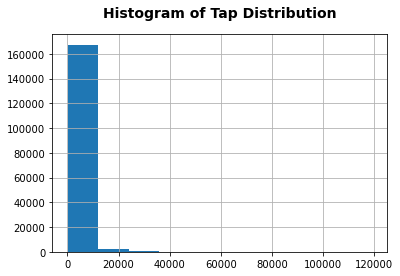

In [8]:
# check the distribution of total tap volume
opal["Taps_in_total"].hist()
plt.title('Histogram of Tap Distribution', fontsize=14, fontweight='bold',loc = 'center', y=1.05)

- From the Histogram, an extremely leftward skewed distribution is observed, thus, we decided to normalise the data by logging the data for analysis purposes.

In [9]:
# log the data
opal['logTap_Ons'] = np.log10(opal.Adjusted_Tap_Ons)
opal['logTap_Offs'] = np.log10(opal.Adjusted_Tap_Offs)
opal['logTaps_in_total'] = np.log10(opal.Taps_in_total)

In [10]:
# Checking the result of normalisation
opal.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
tap_hour,-0.115998,-1.062266
Adjusted_Tap_Ons,14.797408,344.624424
Adjusted_Tap_Offs,17.841049,500.188224
Taps_in_total,10.987337,185.571786
logTap_Ons,0.824272,-0.090569
logTap_Offs,0.879931,0.052115
logTaps_in_total,0.844561,-0.064197


- The skewness for tap in total shapely reduced from 10.98 to 0.84 after logging, which is still slightly skewed. However, due to large sample size, it is acceptable to assume normality due to Central Limit Theorem. 

## Opal User's Travel Pattern Analysis

We look at travel patterns from opal usage by:
1. Travel Frequency (How often)
2. Time of Travel (When)
3. Travel Regions (Where)
4. Travel Mode Preferences (Modes)

### 1. Travel Frequency of Opal Users in NSW

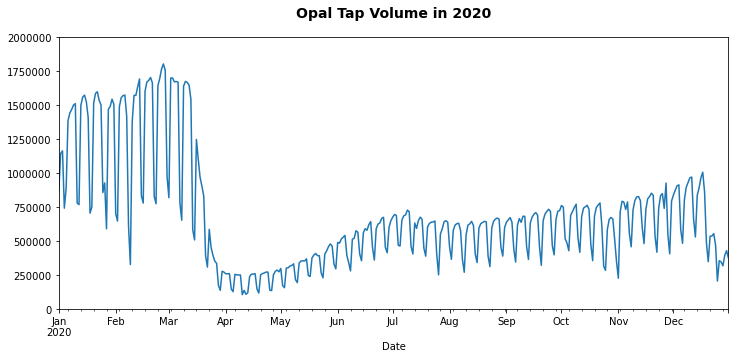

In [11]:
## group data by date
opal_total = opal.groupby(['trip_origin_date'] )['Taps_in_total'].sum()

## visualise the travel frequency in time series
fig, ax =plt.subplots(figsize=(12,5))
opal_total.plot(kind='line')
plt.title('Opal Tap Volume in 2020', fontsize=14, fontweight='bold',loc = 'center', y=1.05)
plt.xlabel("Date")

# setting the yticks to have 0 decimal place to show all digits
yy, locs = plt.yticks()
ll = ['%.f' % a for a in yy]
plt.yticks(yy, ll)
plt.show()

- The maximum opal usage happened in late February with around 1.75 million usage, where the lowest usage was in mid-April with less than 100000 usage.
- _**Please note that the sharp fall in usage from April onwards is coincided with the time where government imposed COVID-19 restrictions on travelling. As a result, "months" will not be included as a factor in our estimation model since this is affected by a one-time event.**_

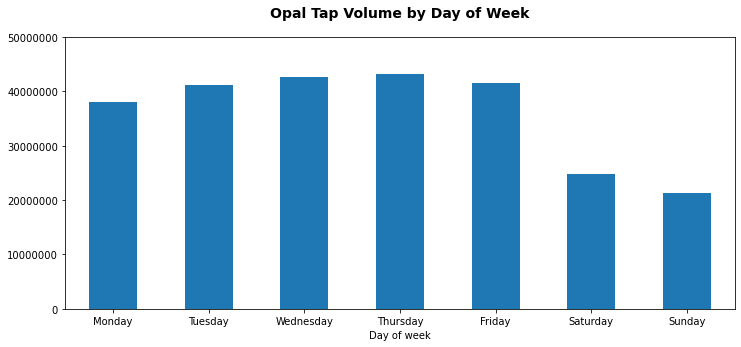

In [12]:
## get the day of week in order
opal['day_of_week'] = pd.Categorical(opal['day_of_week'], 
                                     categories= 
                                     ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
                                     ordered=True)

## take a closer look in the pattern where day of week is used to categorised the data
opal_weekly = opal.groupby(['day_of_week'] )['Taps_in_total'].sum()

fig, ax =plt.subplots(figsize=(12,5))
opal_weekly.plot(kind ='bar')
plt.title('Opal Tap Volume by Day of Week', fontsize=14, fontweight='bold',loc = 'center', y=1.05)
plt.xlabel("Day of week")
plt.xticks(rotation=0)

# setting the yticks to have 0 decimal place to show all digits
yy, locs = plt.yticks()
ll = ['%.f' % a for a in yy]
plt.yticks(yy, ll)
plt.show()

- The graph above shows a weekly pattern of opal usage across all transport mode. 
- It is observed that weekdays generated more tap volume than weekends.

Create a dummy variable for weekday versus weekend for further exploration and testing in regression analysis.

In [13]:
# create a new variable to categorize weekday and weekend for regression analysis later
result = []
for x in opal ['day_of_week']:
    if x == 'Saturday':
        result.append('0')
    elif x == 'Sunday':
        result.append('0')
    else:
        result.append('1')
        
opal["Weekday_reg"] = result   

Text(0.5, 1.05, 'Countplot of Weekday Taps')

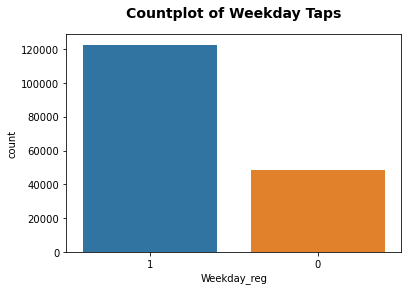

In [14]:
# visualise the difference between weekday and weekend
sns.countplot(x = "Weekday_reg", data = opal)
plt.title('Countplot of Weekday Taps', fontsize=14, fontweight='bold',loc = 'center', y=1.05)

### 2. When did Opal Users Travel

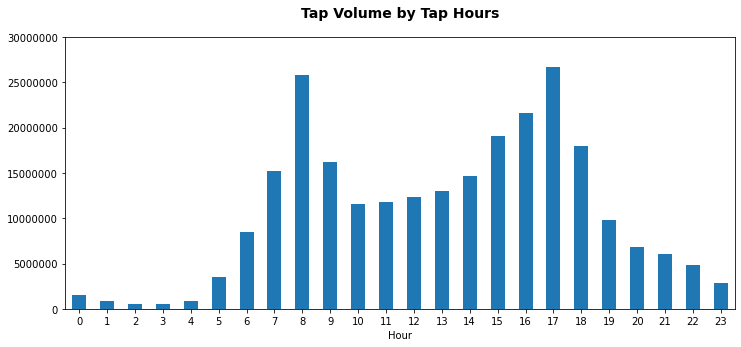

In [15]:
## group data by time
opal_hour = opal.groupby(['tap_hour'] )['Taps_in_total'].sum()

## visualise the travel frequency in time series
fig, ax =plt.subplots(figsize=(12,5))
opal_hour.plot(kind='bar')
plt.title('Tap Volume by Tap Hours', fontsize=14, fontweight='bold',loc = 'center', y=1.05)
plt.xlabel("Hour")
plt.xticks(rotation=0)

# setting the yticks to have 0 decimal place to show all digits
yy, locs = plt.yticks()
ll = ['%.f' % a for a in yy]
plt.yticks(yy, ll)
plt.show()

- Mid-night hours from 12 am - 6 am reported with fairly low usage.
- The peak hours of usage is at 8 am (total tap volume at 25,826,300) and 5 pm (total tap volume at 26,685,900), which can be reasonably explained by the offices working hours in general.

Create a dummy variable for peak hours versus non-peak hours for further exploration and testing in regression analysis.

In [16]:
## create a new variable for peak vs non-peak hours
result = []
for x in opal ['tap_hour']:
    if x == 8:
        result.append('1')
    elif x > 14 and x < 18:
        result.append('1')
    else:
        result.append('0')
        
opal["peak_hour"] = result   

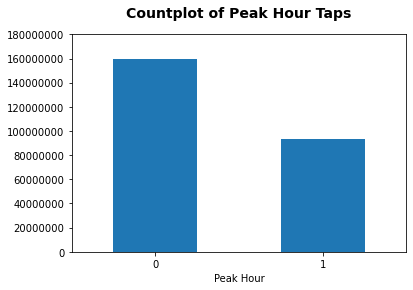

In [17]:
## group data by time
opal_peak = opal.groupby(["peak_hour"] )['Taps_in_total'].sum()

## visualise the travel frequency by peak hours vs non-peak hours
opal_peak.plot(kind='bar')
plt.title('Countplot of Peak Hour Taps', fontsize=14, fontweight='bold',loc = 'center', y=1.05)
plt.xlabel("Peak Hour")
plt.xticks(rotation=0)

# setting the yticks to have 0 decimal place to show all digits
yy, locs = plt.yticks()
ll = ['%.f' % a for a in yy]
plt.yticks(yy, ll)
plt.show()

Create a dummy variable for midnight hours versus non-midnight hours for further exploration and testing in regression analysis.

In [18]:
## create a new variable for midnight vs non-midnight
result = []
for x in opal ['tap_hour']:
    if x > 0 and x < 6:
        result.append('1')
    else:
        result.append('0')
        
opal["midnight_hour"] = result   

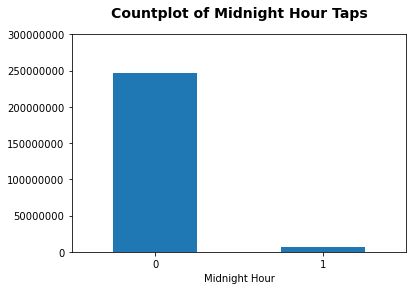

In [19]:
## group data by time
opal_peak = opal.groupby(["midnight_hour"] )['Taps_in_total'].sum()

## visualise the travel frequency in time series
opal_peak.plot(kind='bar')
plt.title('Countplot of Midnight Hour Taps', fontsize=14, fontweight='bold',loc = 'center', y=1.05)
plt.xlabel("Midnight Hour")
plt.xticks(rotation=0)

# setting the yticks to have 0 decimal place to show all digits
yy, locs = plt.yticks()
ll = ['%.f' % a for a in yy]
plt.yticks(yy, ll)
plt.show()


### 3. Where Do Opal Users Travel

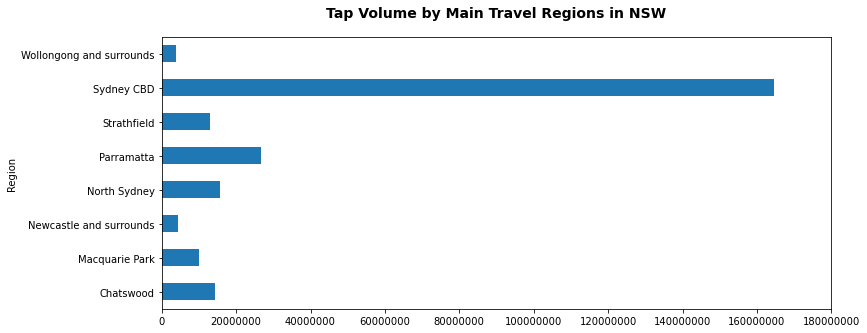

In [20]:
# Looking at the top region of NSW where people commonly travel
opal_LGA = opal.groupby(['ti_region'] )['Taps_in_total'].sum()

# Visualizing the data
fig, ax =plt.subplots(figsize=(12,5))
opal_LGA.plot(kind='barh')
plt.title('Tap Volume by Main Travel Regions in NSW', fontsize=14, fontweight='bold',loc = 'center', y=1.05)
plt.ylabel("Region")

# setting the xticks to have 0 decimal place to show all digits
xx, locs = plt.xticks()
ll = ['%.f' % a for a in xx]
plt.xticks(xx, ll)
plt.show()

- From the graph above, Sydney CBD is the top region where people commonly travel to and from, followed by Paramatta, then North Sydney.

Plot a Heatmap to show relationship between travel regions and tap hours:

Text(0.5, 105.54000000000005, 'Hour')

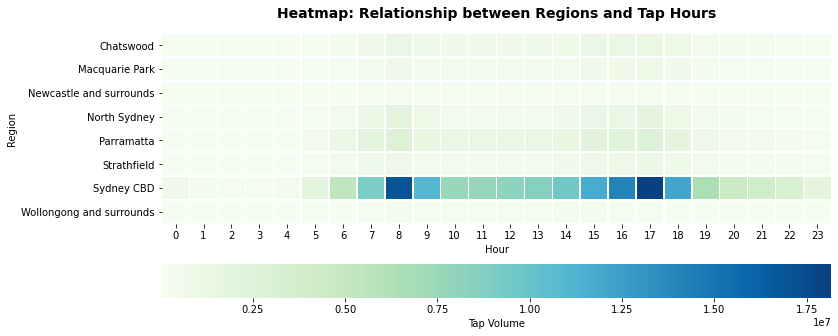

In [21]:
# rearrange the data to generate a heatmap
opal_LGA_hour = opal.groupby(['tap_hour','ti_region'] )['Taps_in_total'].sum().reset_index()
Counts = opal_LGA_hour.pivot(index = 'ti_region', columns ='tap_hour', values = 'Taps_in_total')
plt.figure(figsize=(12, 5))
plt.title('Heatmap: Relationship between Regions and Tap Hours', fontsize=14, fontweight='bold',loc = 'center', y=1.05)

cbar_kws = {"orientation": "horizontal",
            'label':'Tap Volume'}

sns.heatmap(Counts, cmap ="GnBu", linewidths=.5, cbar_kws=cbar_kws)
plt.ylabel("Region")
plt.xlabel("Hour")

From the heatmap above, 
- the opal usage is coincided with the pattern of peak vs non-peak hour, which may indicate the time of taps is important for our model estimation.
- Sydney CBD is the main spot of travel for opal users. 

### 4. Travel Mode Preferences

In [22]:
# Looking at tap volume by transport modes
opal_mode = opal.groupby("mode_name")["Taps_in_total"].sum()

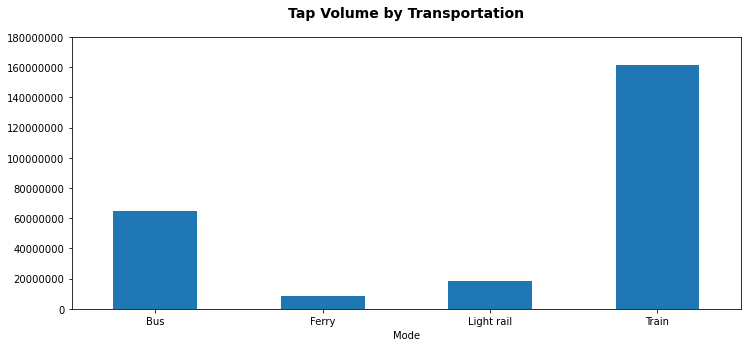

In [23]:
## visualise the travel mode preferences
fig, ax =plt.subplots(figsize=(12,5))
opal_mode.plot(kind='bar')
plt.title('Tap Volume by Transportation', fontsize=14, fontweight='bold',loc = 'center', y=1.05)
plt.xlabel("Mode")
plt.xticks(rotation=0)

# setting the yticks to have 0 decimal place to show all digits
yy, locs = plt.yticks()
ll = ['%.f' % a for a in yy]
plt.yticks(yy, ll)
plt.show()

- From the graph above, it is clear that train is the most popular transport in NSW, followed by bus. The opal usage for train is more than double of that for bus. Ferry is the least common transport in NSW.

Plot a Heatmap to show relationship between transport modes and tap hours:

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Bus'),
  Text(0, 1.5, 'Ferry'),
  Text(0, 2.5, 'Light rail'),
  Text(0, 3.5, 'Train')])

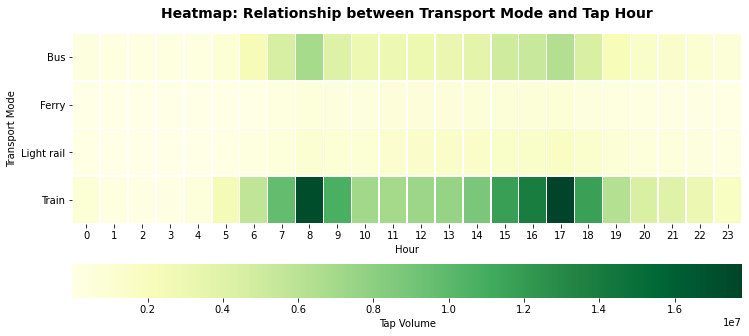

In [24]:
# rearrange the data to generate a heatmap
opal_LGA_hour = opal.groupby(['tap_hour','mode_name'] )['Taps_in_total'].sum().reset_index()
Counts = opal_LGA_hour.pivot(index = 'mode_name', columns ='tap_hour', values = 'Taps_in_total')
plt.figure(figsize=(12, 5))
plt.title('Heatmap: Relationship between Transport Mode and Tap Hour', fontsize=14, fontweight='bold',loc = 'center', y=1.05)

cbar_kws = {"orientation": "horizontal",
            'label':'Tap Volume'}

sns.heatmap(Counts, cmap ="YlGn", linewidths=.5, cbar_kws=cbar_kws)
plt.ylabel("Transport Mode")
plt.xlabel("Hour")
plt.yticks(rotation=0)

From the heatmap above,
- the usage by transport mode is also coincided with the pattern of peak vs non-peak hour, which may indicate time of taps is important for our model estimation.
- the usage of train and bus seem to be largely affected by rush hours, while ferry seems to be least affected by that.

## Demographics Factors

We explore different demographic varaibles to see if there is any relations to opal usage.

### Combine Opal Data with HTS Data

In [25]:
# adding new data set with data by LGA , and match opal regions with LGA
xls = pd.ExcelFile('data/HTS Data by LGA.xlsx')
demogr = pd.read_excel(xls, 'Demographics by LGA')
demogr.head()

,WAVE,REGION_ID,REGION_NAME,LGA_ID,LGA_NAME,AREA_SQ_KM,WEIGHTED_POPULATION,WEIGHTED_HOUSEHOLDS,WEIGHTED_VEHICLES,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,2016/17,1,Sydney GCCSA,750,Blacktown,240,341000,115000,203000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016/17,1,Sydney GCCSA,900,Blue Mountains,1431,76000,30000,53000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016/17,1,Sydney GCCSA,1100,Botany Bay,22,47000,17000,23000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016/17,1,Sydney GCCSA,1300,Burwood,7,35000,11000,17000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016/17,1,Sydney GCCSA,1450,Camden,201,79000,27000,60000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Combine the opal dataset with demographic data by region using Local Government Areas (LGA) as below:

|  Region Name in Opal      |  LGA Name     |
|:--------------------------|:--------------|
|  Chatswood                |  Willoughby   |
|  Macquarie Park           |  Ryde         |
|  Newcastle and surrounds  |  Newcastle    |
|  North Sydney             |  North Sydney |
|  Parramatta               |  Parramatta   |
|  Strathfield              |  Strathfield  |
|  Sydney CBD               |  Sydney       |
|  Wollongong and surrounds |  Wollongong   |

In [26]:
# match the regions to its corresponding LGA
conditions = [
    opal.ti_region=='Chatswood', opal.ti_region=='Macquarie Park',
    opal.ti_region=='Newcastle and surrounds', opal.ti_region=='North Sydney',
    opal.ti_region=='Wollongong and surrounds', opal.ti_region=='Parramatta',
    opal.ti_region=='Strathfield', opal.ti_region=='Sydney CBD'
    ]

# create a list of the values we want to assign for each condition
values = ['Willoughby', 'Ryde',
          'Newcastle', 'North Sydney',
         'Wollongong', 'Parramatta',
         'Strathfield', 'Sydney']

# create a new column and use np.select to assign values to it using our lists as arguments
opal['LGA'] = np.select(conditions, values)
opal.head()

,trip_origin_date,month,mode_name,ti_region,tap_hour,Adjusted_Tap_Ons,Adjusted_Tap_Offs,Taps_in_total,day_of_week,logTap_Ons,logTap_Offs,logTaps_in_total,Weekday_reg,peak_hour,midnight_hour,LGA
0,2020-01-01,Jan,Bus,Chatswood,0,50,50,100,Wednesday,1.698970,1.69897,2.000000,1,0,0,Willoughby
1,2020-01-01,Jan,Bus,Macquarie Park,0,50,50,100,Wednesday,1.698970,1.69897,2.000000,1,0,0,Ryde
2,2020-01-01,Jan,Bus,Newcastle and surrounds,0,50,50,100,Wednesday,1.698970,1.69897,2.000000,1,0,0,Newcastle
3,2020-01-01,Jan,Bus,North Sydney,0,700,100,800,Wednesday,2.845098,2.00000,2.903090,1,0,0,North Sydney
5,2020-01-01,Jan,Bus,Parramatta,0,100,50,150,Wednesday,2.000000,1.69897,2.176091,1,0,0,Parramatta


In [27]:
# extract only data in 2019/20
new_demogr = demogr[demogr['WAVE'] == '2019/20']

In [28]:
# create pivot table based on the LGA
table = pd.pivot_table(new_demogr, values=['AREA_SQ_KM', 'WEIGHTED_POPULATION', 'WEIGHTED_HOUSEHOLDS', 'WEIGHTED_VEHICLES'],
                       index=['LGA_NAME'])

In [29]:
# combine two datasets according to the LGA name
opal_demogr = opal.join(table, on='LGA')
opal_demogr.head()

,trip_origin_date,month,mode_name,ti_region,tap_hour,Adjusted_Tap_Ons,Adjusted_Tap_Offs,Taps_in_total,day_of_week,logTap_Ons,logTap_Offs,logTaps_in_total,Weekday_reg,peak_hour,midnight_hour,LGA,AREA_SQ_KM,WEIGHTED_HOUSEHOLDS,WEIGHTED_POPULATION,WEIGHTED_VEHICLES
0,2020-01-01,Jan,Bus,Chatswood,0,50,50,100,Wednesday,1.698970,1.69897,2.000000,1,0,0,Willoughby,22,29000,78000,46000
1,2020-01-01,Jan,Bus,Macquarie Park,0,50,50,100,Wednesday,1.698970,1.69897,2.000000,1,0,0,Ryde,40,47000,125000,76000
2,2020-01-01,Jan,Bus,Newcastle and surrounds,0,50,50,100,Wednesday,1.698970,1.69897,2.000000,1,0,0,Newcastle,187,66000,160000,113000
3,2020-01-01,Jan,Bus,North Sydney,0,700,100,800,Wednesday,2.845098,2.00000,2.903090,1,0,0,North Sydney,10,36000,73000,42000
5,2020-01-01,Jan,Bus,Parramatta,0,100,50,150,Wednesday,2.000000,1.69897,2.176091,1,0,0,Parramatta,84,88000,245000,144000


### Combine Data with Personal Income

In [30]:
xls = pd.ExcelFile('data/Personal income in Australia.xls')
income = pd.read_excel(xls, sheet_name='Table 1.5', usecols='B,I,P,W,AD,AK', skiprows=5)
income.head()

,Unnamed: 1,Unnamed: 8,Unnamed: 15,Unnamed: 22,Unnamed: 29,Unnamed: 36
0,LGA NAME,2017-18,2017-18,2017-18,2017-18,2017-18
1,NaN,14069082,42,903888674402,49805,64246
2,NaN,4466941,42,300176988652,50153,67200
3,Albury,29898,43,1686539002,47732,56410
4,Armidale Regional,15913,44,828631202,42220,52073


In [31]:
income = income.rename(columns={'Unnamed: 1':'LGA NAME', 'Unnamed: 8':'Earners (persons)', 
                                'Unnamed: 15':'Median age of earners (years)', 'Unnamed: 22':'Sum ($)',
                               'Unnamed: 29':'Median ($)', 'Unnamed: 36':'Mean ($)'})

income.head()

,LGA NAME,Earners (persons),Median age of earners (years),Sum ($),Median ($),Mean ($)
0,LGA NAME,2017-18,2017-18,2017-18,2017-18,2017-18
1,NaN,14069082,42,903888674402,49805,64246
2,NaN,4466941,42,300176988652,50153,67200
3,Albury,29898,43,1686539002,47732,56410
4,Armidale Regional,15913,44,828631202,42220,52073


In [32]:
income.set_index('LGA NAME', inplace=True)

In [33]:
# combine all datasets into one
opal_final = opal_demogr.join(income, on='LGA')

In [34]:
# rename column names to run codes
opal_final = opal_final.rename(columns={'Earners (persons)': 'Earners', 
                                        'Median age of earners (years)': 'Earners_Age',
                                        'Sum ($)': 'Sum_Salary',
                                        'Median ($)': 'Median_Salary',
                                        'Mean ($)': 'Mean_Salary'})

In [35]:
## convert all the data type into "float"
opal_final['Weekday_reg'] = pd.to_numeric(opal_final['Weekday_reg'],errors = 'coerce')
opal_final['peak_hour'] = pd.to_numeric(opal_final['peak_hour'],errors = 'coerce')
opal_final['midnight_hour'] = pd.to_numeric(opal_final['midnight_hour'],errors = 'coerce')
opal_final['Earners'] = pd.to_numeric(opal_final['Earners'],errors = 'coerce')
opal_final['Earners_Age'] = pd.to_numeric(opal_final['Earners_Age'],errors = 'coerce')
opal_final['Sum_Salary'] = pd.to_numeric(opal_final['Sum_Salary'],errors = 'coerce')
opal_final['Median_Salary'] = pd.to_numeric(opal_final['Median_Salary'],errors = 'coerce')
opal_final['Mean_Salary'] = pd.to_numeric(opal_final['Mean_Salary'],errors = 'coerce')

In [36]:
opal_final.head()

,trip_origin_date,month,mode_name,ti_region,tap_hour,Adjusted_Tap_Ons,Adjusted_Tap_Offs,Taps_in_total,day_of_week,logTap_Ons,...,LGA,AREA_SQ_KM,WEIGHTED_HOUSEHOLDS,WEIGHTED_POPULATION,WEIGHTED_VEHICLES,Earners,Earners_Age,Sum_Salary,Median_Salary,Mean_Salary
0,2020-01-01,Jan,Bus,Chatswood,0,50,50,100,Wednesday,1.698970,...,Willoughby,22,29000,78000,46000,50185,43,5135949986,60792,102340
1,2020-01-01,Jan,Bus,Macquarie Park,0,50,50,100,Wednesday,1.698970,...,Ryde,40,47000,125000,76000,76127,39,5229754036,52784,68698
2,2020-01-01,Jan,Bus,Newcastle and surrounds,0,50,50,100,Wednesday,1.698970,...,Newcastle,187,66000,160000,113000,91558,41,6058217032,52649,66168
3,2020-01-01,Jan,Bus,North Sydney,0,700,100,800,Wednesday,2.845098,...,North Sydney,10,36000,73000,42000,51615,40,5898586716,76063,114280
5,2020-01-01,Jan,Bus,Parramatta,0,100,50,150,Wednesday,2.000000,...,Parramatta,84,88000,245000,144000,146880,38,9127438492,50838,62142


## Analysing Travel Patterns with Demographic Variables
### K- means Clustering

We would start with clustering the data on travel pattern combined with demographics features, to understand the big picture of the features of opal users, and ideally identify some demographic feature which may affect the opal volume.

In [37]:
opal_cluster = opal_final.drop(columns = ['trip_origin_date', 'month', 'mode_name', 'ti_region', 'day_of_week', 'LGA'])

In [38]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(opal_cluster)
    distortions.append(kmeanModel.inertia_)

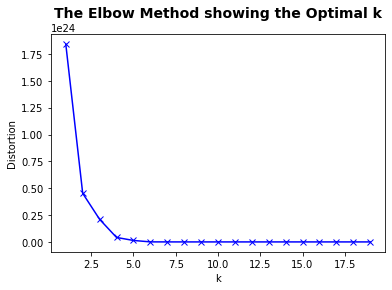

In [39]:
# establish Elbow Method to confirm the best k to start with
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the Optimal k', fontsize=14, fontweight='bold',loc = 'center', y=1.05)
plt.show()

In [40]:
km = KMeans(n_clusters = 4)
km.fit(opal_cluster)
opal_cluster['kcluster'] = km.predict(opal_cluster)

In [41]:
kcluster_mean = opal_cluster.groupby(['kcluster']).agg('mean').round(2)
kcluster_mean

,tap_hour,Adjusted_Tap_Ons,Adjusted_Tap_Offs,Taps_in_total,logTap_Ons,logTap_Offs,logTaps_in_total,Weekday_reg,peak_hour,midnight_hour,AREA_SQ_KM,WEIGHTED_HOUSEHOLDS,WEIGHTED_POPULATION,WEIGHTED_VEHICLES,Earners,Earners_Age,Sum_Salary,Median_Salary,Mean_Salary
kcluster,,,,,,,,,,,,,,,,,,,
0,12.49,240.77,238.05,478.81,2.08,2.07,2.39,0.72,0.19,0.13,170.72,52481.26,128722.23,83417.85,76451.11,41.08,5.896557e+09,59023.24,83012.97
1,12.02,2489.88,2476.07,4965.95,2.89,2.85,3.19,0.72,0.18,0.16,27.00,97000.00,210000.00,87000.00,157214.00,33.00,1.285496e+10,54628.00,81767.00
2,11.58,379.50,360.97,740.47,2.34,2.30,2.63,0.72,0.17,0.20,14.00,16000.00,46000.00,23000.00,28276.00,35.00,1.859895e+09,46484.00,65776.00
3,11.84,698.94,682.88,1381.82,2.50,2.49,2.80,0.71,0.19,0.17,84.00,88000.00,245000.00,144000.00,146880.00,38.00,9.127438e+09,50838.00,62142.00


K-means clustering indicated to divided patterns into 4 groups, where there were distinctive in terms of demographics, 
- there does not indicate much difference from tap hour.
- **Group 0**: with lowest tap volume,largest regional area, highest earner age, highest number of earners and highest mean salary
- **Group 1**: with highest tap volume , second smallest regional area, lowest earner age, second highest in mean salary
- **Group 2**: with second lowest tap volume ,smallest regional area, second lowest earner age, second lowest in number of earners and lowest mean salary
- **Group 3**: with second highest tap volume, second largest regional area, second highest earner age, lowest mean salary

We will proceed to explore any relationships in regression model.

Text(0.5, 1.05, 'Scatter Plot of tap on and tap off values by k-means clusters')

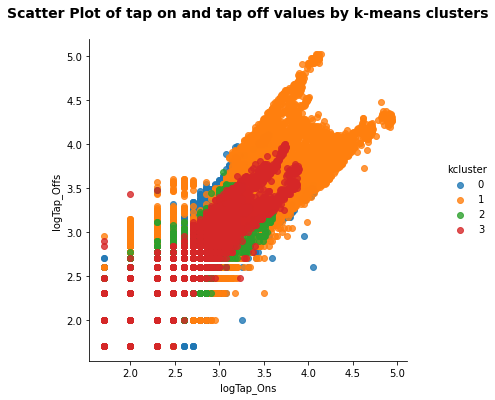

In [42]:
# visualisation by k-means categories
# plot the diagram
sns.lmplot(x='logTap_Ons', y='logTap_Offs', data=opal_cluster, fit_reg=False, hue = 'kcluster')
plt.title("Scatter Plot of tap on and tap off values by k-means clusters", fontsize=14, fontweight='bold',loc = 'center', y=1.05)

### Get Dummies for transport mode

In [43]:
cat_vars=['mode_name']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(opal_final[var], prefix=var)
    opal_final_1 = opal_final.join(cat_list)
    opal_final = opal_final_1

### Regression Analysis

In [44]:
## drop irrelevant data before transformation

opal_final = opal_final.drop(["Taps_in_total","Adjusted_Tap_Ons","Adjusted_Tap_Offs", "logTap_Ons", "logTap_Offs"], axis = 1)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 [Text(0.5, 0, 'tap_hour'),
  Text(1.5, 0, 'logTaps_in_total'),
  Text(2.5, 0, 'Weekday_reg'),
  Text(3.5, 0, 'peak_hour'),
  Text(4.5, 0, 'midnight_hour'),
  Text(5.5, 0, 'AREA_SQ_KM'),
  Text(6.5, 0, 'WEIGHTED_HOUSEHOLDS'),
  Text(7.5, 0, 'WEIGHTED_POPULATION'),
  Text(8.5, 0, 'WEIGHTED_VEHICLES'),
  Text(9.5, 0, 'Earners'),
  Text(10.5, 0, 'Earners_Age'),
  Text(11.5, 0, 'Sum_Salary'),
  Text(12.5, 0, 'Median_Salary'),
  Text(13.5, 0, 'Mean_Salary'),
  Text(14.5, 0, 'mode_name_Bus'),
  Text(15.5, 0, 'mode_name_Ferry'),
  Text(16.5, 0, 'mode_name_Light rail'),
  Text(17.5, 0, 'mode_name_Train')])

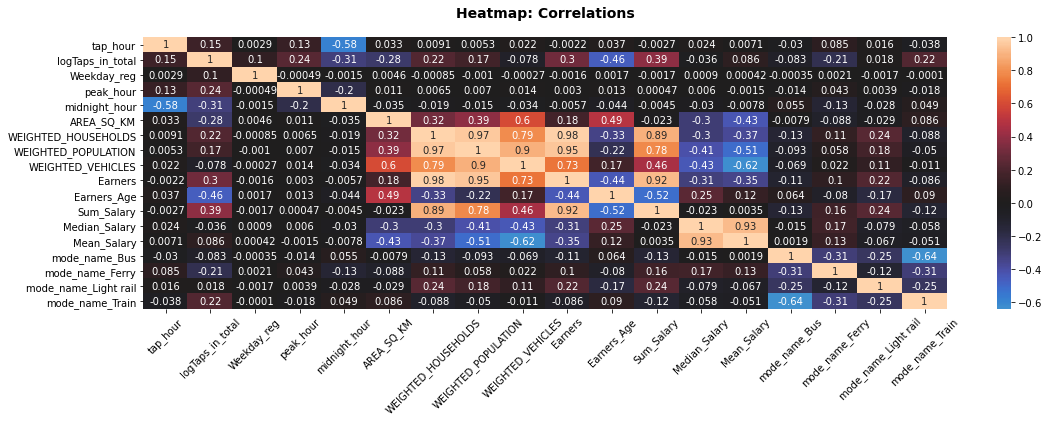

In [45]:
opal_hm = opal_final.corr()
plt.figure(figsize=(18, 5))
sns.heatmap(opal_hm, annot = True , center=0)
plt.title('Heatmap: Correlations', fontsize=14, fontweight='bold',loc = 'center', y=1.05)
plt.xticks(rotation=45)

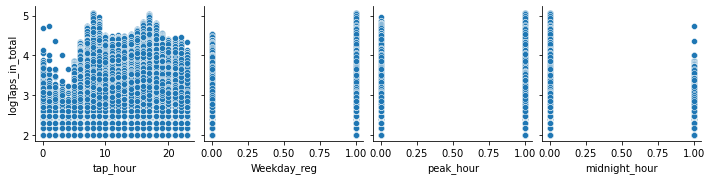

In [46]:
## for seasonal and traffic-pattern related items, take a look at some pairplot to see if there are any features.
sns.pairplot(
    opal_final,
    x_vars =["tap_hour", "Weekday_reg", "peak_hour", "midnight_hour"],
    y_vars =["logTaps_in_total"]
)

- From the scatter plots above, seems no special relationship can be drawn.

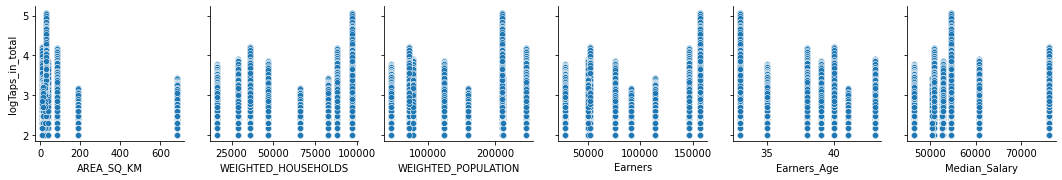

In [47]:
## for demographic items, take a look at some pairplot to see if there are any features.

sns.pairplot(
    opal_final,
    x_vars =["AREA_SQ_KM", "WEIGHTED_HOUSEHOLDS", "WEIGHTED_POPULATION", "Earners", "Earners_Age", "Median_Salary"],
    y_vars =["logTaps_in_total"]
)

- From the scatter plots above, seems weak linear relationships can be drawn.

### Feature Selection (RFE)

In [48]:
train, test = train_test_split(opal_final, test_size=0.2, random_state=142)

train.head()

,trip_origin_date,month,mode_name,ti_region,tap_hour,day_of_week,logTaps_in_total,Weekday_reg,peak_hour,midnight_hour,...,WEIGHTED_VEHICLES,Earners,Earners_Age,Sum_Salary,Median_Salary,Mean_Salary,mode_name_Bus,mode_name_Ferry,mode_name_Light rail,mode_name_Train
53731,2020-04-04,Apr,Ferry,Newcastle and surrounds,21,Saturday,2.000000,0,0,0,...,113000,91558,41,6058217032,52649,66168,0,1,0,0
178078,2020-11-15,Nov,Train,Newcastle and surrounds,9,Sunday,2.176091,0,0,0,...,113000,91558,41,6058217032,52649,66168,0,0,0,1
192681,2020-12-11,Dec,Light rail,Sydney CBD,14,Friday,3.770852,1,0,0,...,87000,157214,33,12854964329,54628,81767,0,0,1,0
141597,2020-09-11,Sep,Train,Strathfield,4,Friday,2.176091,1,0,1,...,23000,28276,35,1859894858,46484,65776,0,0,0,1
163235,2020-10-20,Oct,Bus,Wollongong and surrounds,19,Tuesday,2.000000,1,0,0,...,138000,113903,43,7138541170,50484,62672,1,0,0,0


In [49]:
X_train = train.drop(["logTaps_in_total", "trip_origin_date","month","tap_hour","mode_name","ti_region","day_of_week","LGA"], axis = 1)
y_train = train["logTaps_in_total"]
X_test = test.drop(["logTaps_in_total", "trip_origin_date","month","tap_hour","mode_name","ti_region","day_of_week","LGA"], axis = 1)
y_test = test["logTaps_in_total"]

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [50]:
# Fitting RFE Model and printing best RFE model
rfecv = RFECV(
    estimator=LinearRegression(),
    min_features_to_select=1,
    step=1,
    scoring="r2"
)

_ = rfecv.fit(X_train, y_train)

X_train.columns[rfecv.support_]

Index(['Weekday_reg', 'peak_hour', 'midnight_hour', 'AREA_SQ_KM',
       'WEIGHTED_HOUSEHOLDS', 'WEIGHTED_POPULATION', 'WEIGHTED_VEHICLES',
       'Earners', 'Earners_Age', 'Median_Salary', 'Mean_Salary',
       'mode_name_Bus', 'mode_name_Ferry', 'mode_name_Light rail',
       'mode_name_Train'],
      dtype='object')

In [51]:
rfe = RFE(estimator = model, n_features_to_select=15, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [52]:
# summarize all features
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 2.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000


In [53]:
y = train['logTaps_in_total']
col = [ 'Weekday_reg', 'peak_hour', 'midnight_hour', 'AREA_SQ_KM',
       'WEIGHTED_HOUSEHOLDS', 'WEIGHTED_POPULATION', 'WEIGHTED_VEHICLES',
       'Earners', 'Earners_Age', 'Median_Salary', 'Mean_Salary',
       'mode_name_Bus', 'mode_name_Ferry', 'mode_name_Light rail',
       'mode_name_Train' 
        ]

X = train[col]

In [54]:
## confirm the significance of factors using z-score and p-values
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       logTaps_in_total   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                 1.719e+04
Date:                Wed, 03 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:22:26   Log-Likelihood:                -61354.
No. Observations:              136817   AIC:                         1.227e+05
Df Residuals:                  136803   BIC:                         1.229e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0023 

## Estimation Model (Multiple Linear Regression)

Drop "Mean_Salary" in building the model since mean salary is kind of a duplication to "Median_Salary".

In [55]:
X_train_final = train.drop(["logTaps_in_total", "trip_origin_date","month","tap_hour","mode_name","ti_region","day_of_week","LGA", "WEIGHTED_VEHICLES", "Mean_Salary"], axis = 1)
y_train_final = train["logTaps_in_total"]
X_test_final = test.drop(["logTaps_in_total", "trip_origin_date","month","tap_hour","mode_name","ti_region","day_of_week","LGA", "WEIGHTED_VEHICLES", "Mean_Salary"], axis = 1)
y_test_final = test["logTaps_in_total"]

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [56]:
## checking the independent variables in final model
X_train_final.columns

Index(['Weekday_reg', 'peak_hour', 'midnight_hour', 'AREA_SQ_KM',
       'WEIGHTED_HOUSEHOLDS', 'WEIGHTED_POPULATION', 'Earners', 'Earners_Age',
       'Sum_Salary', 'Median_Salary', 'mode_name_Bus', 'mode_name_Ferry',
       'mode_name_Light rail', 'mode_name_Train'],
      dtype='object')

In [57]:
print(f'y = x*{model.coef_} + {model.intercept_}')

y = x*[ 1.45524452e-01  3.16315594e-01 -5.99606427e-01 -4.32960956e-06
  5.64000477e-07 -9.92812305e-06 -1.17989633e-05  5.66044582e-05
 -7.95164696e-08 -4.10166068e-10 -1.45633309e-05  2.47797586e-05
  9.10352520e-02 -3.91356623e-01 -4.10715579e-02  3.41392929e-01] + 1.308527601205841


In [58]:
y_pred = model.predict(X_test)
y_pred

array([3.1791279 , 3.766353  , 2.08898269, ..., 2.41452287, 3.19967973,
       1.60239776])

In [59]:
## review the performance of final model
print("MSE: ", mean_squared_error(y_test, y_pred)) 
print("R-square: ", r2_score(y_test, y_pred))

MSE:  0.14096140477520233
R-square:  0.624981670203033


**Findings:** 
- After RFE Selection, 14 variables are manually selected to fit the model. 
- R-square is reported as 0.625, meaning 62.5% of tap volume can be explained by the independent variables, this is a moderately well model in explaining the volume of opal taps.


## Conclusion

- Train is the most popular transport in all times. It seems that train is the fastest or most convenient mode of transport in our insight regions.

- Tap-volume and transport patterns are more likely based on necessity to travel. It is observed that more tap volume on peak hour and less over midnight. 

- Echo with k-means clustering, the regression model also indicated the regional income may have impact over the Tap-volume. This may due to purposes of travelling, implying most opal users may use public transports for work-purpose.



## Review on Project

Throughout the project, we encounter a lot of difficulties in data extraction and modelling. The original data is stored without demographics, we spend so much times in researching for demographic data that can matach with our opal usage dataset, as well as producing meaningful results. We eventually made some assumptions on the time range of data extraction, since we are unable to match data with the exact time frame across different datasets. 

Eventually the data comes out well with a moderately well explanatory model. While with more time allowed, we would work on a dataset with a longer time frame to eliminate any COVID related impact. Moreover, the data analysis would be more ideal if the data set itself is collected on individual level than on grouped level.